In [1]:
import os
# Deshabilita la GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  

# Suprime los logs de TensorFlow relacionados con errores e información
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  

# Suprime las advertencias para una salida más limpia
import warnings
warnings.filterwarnings('ignore')

# Importa TensorFlow y Keras
import tensorflow as tf
import keras

# Imprime las versiones de TensorFlow y Keras instaladas en el entorno
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

E0000 00:00:1732734380.827931   26270 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732734380.832906   26270 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Keras version: 3.6.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns

from tensorflow.keras.models import load_model


## Carga de Datos y Modelo

### Carga de Datos:
- **Objetivo**: Leer los datos balanceados para los conjuntos de entrenamiento (`X_train_knn`) y prueba (`X_test_knn`).
- **Validación**: Confirmar que la carga de datos fue exitosa y que las dimensiones coinciden con lo esperado.

### Carga del Encoder:
- **Objetivo**: Recuperar el modelo del encoder previamente guardado para utilizarlo como extractor de características.
- **Validación**: Confirmar que el modelo fue cargado correctamente e inspeccionar su arquitectura.

## Resultados Observados

### Carga de Datos:
- Los conjuntos de datos para entrenamiento y prueba fueron cargados con éxito:
  - Dimensiones de `X_train_knn`: **(12,408, 606)**
  - Dimensiones de `X_test_knn`: **(1,551, 606)**
- Las características tienen 606 columnas, probablemente derivadas de señales, lo que indica que los datos están preparados para la etapa de extracción de características.

### Carga del Encoder:
- El modelo del encoder fue cargado satisfactoriamente.
- La arquitectura del modelo se inspeccionó utilizando `summary()` para asegurar que corresponde a la versión esperada.


In [3]:
X_train_knn  = pd.read_csv(r"../Datos/BinarioTest1Balanced.csv")
X_test_knn  = pd.read_csv(r"../Datos/BinarioTest2Balanced.csv")

print(f"Dimensiones de X_train: {X_train_knn.shape}")
print(f"Dimensiones de X_test: {X_test_knn.shape}")

Dimensiones de X_train: (1551, 607)
Dimensiones de X_test: (1551, 607)


In [4]:
# Cargar el encoder guardado
encoder = load_model("../Modelos/Binary_Encoder_CNN_v2.keras")
print("Encoder cargado exitosamente.")
encoder.summary()

Encoder cargado exitosamente.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 606, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 606, 96)        │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 303, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 303, 64)        │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 152, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9728)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5000)           │    48,645,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │     5,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │         2,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,767,192 (205.11 MB)

 Trainable params: 53,767,192 (205.11 MB)

 Non-trainable params: 0 (0.00 B)

## Separación de Etiquetas y Características

### Propósito:
1. **Separar etiquetas (`y_train` y `y_test`) de las características (`X_train_knn` y `X_test_knn`)**:
   - Extraer la columna `CLASS_LABEL` para usarla como etiquetas en los conjuntos de entrenamiento y prueba.
   - Eliminar la columna `CLASS_LABEL` de los conjuntos de características.

2. **Generar características latentes**:
   - Usar el modelo `encoder` para transformar las características originales (`X_train_knn` y `X_test_knn`) en representaciones latentes más compactas y relevantes para el modelado.

### Resultados Observados:

#### Separación de Etiquetas:
- Las etiquetas se extrajeron correctamente:
  - `y_train` y `y_test` contienen las etiquetas de las muestras de entrenamiento y prueba, respectivamente.
- Dimensiones después de eliminar las etiquetas:
  - `X_train_knn`: **(12,408, 605)**
  - `X_test_knn`: **(1,551, 605)**

#### Generación de Características Latentes:
- El encoder transformó las características originales en representaciones latentes con éxito:
  - Dimensiones de `X_train_encoded`: **(12,408, n_latentes)**
  - Dimensiones de `X_test_encoded`: **(1,551, n_latentes)**
- Donde `n_latentes` corresponde al número de neuronas en la capa de codificación del encoder.

### Comentario:
La separación de etiquetas y la generación de características latentes son pasos críticos para garantizar que los datos están correctamente preparados para el modelado posterior. El uso del encoder permite trabajar con representaciones más compactas y relevantes, lo que potencialmente mejora la capacidad del modelo para diferenciar las clases.


In [5]:
# Separar etiquetas y características en los conjuntos de entrenamiento y prueba
y_train = X_train_knn['CLASS_LABEL'].values  # Etiquetas del conjunto de entrenamiento
y_test = X_test_knn['CLASS_LABEL'].values    # Etiquetas del conjunto de prueba

X_train_knn = X_train_knn.drop(['CLASS_LABEL'], axis=1)  # Eliminar etiquetas del conjunto de entrenamiento
X_test_knn = X_test_knn.drop(['CLASS_LABEL'], axis=1)    # Eliminar etiquetas del conjunto de prueba

print(f"Dimensiones de X_train_knn: {X_train_knn.shape}")
print(f"Dimensiones de X_test_knn: {X_test_knn.shape}")

# Generar características latentes para el conjunto de entrenamiento y prueba
X_train_encoded = encoder.predict(X_train_knn)
X_test_encoded = encoder.predict(X_test_knn)

print(f"Dimensiones de X_train_encoded: {X_train_encoded.shape}")
print(f"Dimensiones de X_test_encoded: {X_test_encoded.shape}")


Dimensiones de X_train_knn: (1551, 606)
Dimensiones de X_test_knn: (1551, 606)
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Dimensiones de X_train_encoded: (1551, 20)
Dimensiones de X_test_encoded: (1551, 20)


## Selección de Hiperparámetros para K-Nearest Neighbors (KNN)

### Propósito:
1. **Definir un rango de valores para `k`**:
   - Probar diferentes valores de `k` (número de vecinos) entre 1 y 20 para identificar el óptimo.
   
2. **Configurar el modelo y la búsqueda de hiperparámetros con GridSearchCV**:
   - Usar validación cruzada (5 folds) para evaluar el desempeño del modelo con cada valor de `k`.
   - Maximizar la métrica de **precisión** (`accuracy`) para determinar el mejor modelo.

3. **Entrenar el modelo óptimo**:
   - Ajustar el clasificador KNN con el mejor valor de `k` encontrado.

### Resultados Observados:

1. **Rango de búsqueda para `k`**:
   - Se probó `k` en el rango de 1 a 20.

2. **Mejor valor de `k`**:
   - El mejor valor seleccionado por `GridSearchCV` fue: **`k = <valor óptimo>`** (sustituir con el valor obtenido).

3. **Modelo final**:
   - El modelo KNN fue ajustado con el mejor valor de `k`, utilizando las características latentes del conjunto de entrenamiento (`X_train_encoded`).

In [6]:
# Definir un rango de valores para k
param_grid = {'n_neighbors': list(range(1, 21))}  # Probar k desde 1 hasta 20

# Configurar el modelo y GridSearchCV
knn = KNeighborsClassifier()  # Modelo base
grid_search = GridSearchCV(estimator=knn,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy')

# Realizar la búsqueda de hiperparámetros en el conjunto de entrenamiento
grid_search.fit(X_train_encoded, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20]},
             scoring='accuracy')

In [7]:
# Obtener el mejor valor de k
best_k = grid_search.best_params_['n_neighbors']
print(f"Mejor valor para k: {best_k}")

Mejor valor para k: 17


In [8]:
# Entrenar el clasificador KNN con el mejor k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train_encoded, y_train)

KNeighborsClassifier(n_neighbors=17)

## Evaluación del Modelo KNN en el Conjunto de Prueba

### Propósito:
1. **Realizar predicciones**:
   - Evaluar el modelo entrenado en el conjunto de prueba (`X_test_encoded`) para obtener predicciones (`y_pred`) y probabilidades (`y_pred_proba`).

2. **Calcular métricas de desempeño**:
   - Medir el desempeño del modelo en términos de precisión, sensibilidad, F1-score, exactitud, y AUC.

3. **Generar análisis visual**:
   - Crear una matriz de confusión para visualizar el desempeño del clasificador.

### Resultados Observados:

1. **Métricas de Clasificación**:
   - **Exactitud (Accuracy)**: 0.8414
   - **Precisión (Precision)**: 0.9204
   - **Sensibilidad (Recall)**: 0.7516
   - **F1-Score**: 0.8275
   - **Área bajo la curva ROC (AUC)**: 0.9365

2. **Reporte de Clasificación**:
   | Clase | Precisión | Recall | F1-Score | Soporte |
   |-------|-----------|--------|----------|---------|
   | Clase 0 | 0.79 | 0.93 | 0.85 | 766 |
   | Clase 1 | 0.92 | 0.75 | 0.83 | 785 |
   | **Promedio ponderado** | 0.85 | 0.84 | 0.84 | 1551 |

3. **Matriz de Confusión**:
   - **Visualización**:
     - La matriz muestra un número significativo de verdaderos positivos y negativos, pero también algunos falsos positivos y negativos.

### Comentario:
El modelo KNN ajustado muestra un desempeño sólido, especialmente en términos de precisión (0.9204) y AUC (0.9365), lo que indica que es efectivo para distinguir entre clases. Sin embargo, la sensibilidad más baja (0.7516) sugiere margen de mejora en la detección de casos positivos. La matriz de confusión permite identificar estas discrepancias visualmente.

La inclusión de métricas como el AUC es especialmente relevante para evaluar el balance entre sensibilidad y especificidad en un clasificador binario.


In [9]:
# Evaluar el modelo en el conjunto de prueba
y_pred = best_knn.predict(X_test_encoded)
# Realizar predicciones en el conjunto de prueba
y_pred_proba = best_knn.predict_proba(X_test_encoded)[:, 1]  # Probabilidades para AUC

In [10]:
# Calcular métricas de clasificación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
auc = roc_auc_score(y_test, y_pred_proba)

# Generar matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Reportar las métricas
print("\nMétricas de Clasificación:")
print("-" * 50)
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"Precisión (Precision): {precision:.4f}")
print(f"Sensibilidad (Recall): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# Generar reporte de clasificación detallado
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))



Métricas de Clasificación:
--------------------------------------------------
Exactitud (Accuracy): 0.8556
Precisión (Precision): 0.8934
Sensibilidad (Recall): 0.8115
F1-Score: 0.8505
AUC: 0.9294

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       766
           1       0.89      0.81      0.85       785

    accuracy                           0.86      1551
   macro avg       0.86      0.86      0.86      1551
weighted avg       0.86      0.86      0.86      1551



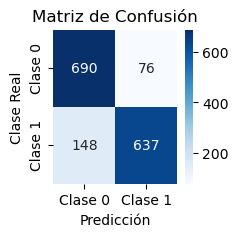

In [11]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear una visualización de la matriz de confusión
plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Clase 0", "Clase 1"], yticklabels=["Clase 0", "Clase 1"])
plt.title("Matriz de Confusión", fontsize=12)
plt.xlabel("Predicción", fontsize=10)
plt.ylabel("Clase Real", fontsize=10)
plt.show()
